In [4]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gc

In [24]:
gc.collect()
torch.cuda.empty_cache()


In [25]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [26]:
torch.cuda.is_available()

True

# My Implementation

In [5]:
# TODO: create transition
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [6]:
# TODO: DQN network

class DQN(nn.Module):

    def __init__(self, n_observations, ff1_size, ff2_size, n_actions):
        super().__init__()
        self.n_observations = n_observations
        self.n_actions = n_actions

        # network
        self.proj1 = nn.Linear(n_observations, ff1_size)
        self.proj2 = nn.Linear(ff1_size, ff2_size)
        self.proj3 = nn.Linear(ff2_size, n_actions)

    def forward(self, x):
        x = F.relu(self.proj1(x))
        x = F.relu(self.proj2(x))
        return self.proj3(x)

In [7]:
# TODO: replay mechanic

class ExperienceReplay:

    def __init__(self, bufferlen) -> None:
        self.memory = deque([], maxlen=bufferlen)

    def add_experience(self, *args):
        self.memory.append(Transition(*args))

    def sample_experience(self, sample_size):
        return random.sample(self.memory, sample_size)

In [8]:
def plot_durations(ep_threshold, show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title(f'prob of explore: {ep_threshold}')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [40]:
def epsilon_greedy(start, end, n_steps, it):
    return max(start - (start - end) * (it / n_steps), end)

In [41]:
def find_next_action(state):
    '''
    Implement the e-greedy policy
    '''
    rand = random.uniform(0,1)
    ep_threshold = epsilon_greedy(1.0, .05, 20000, steps_done)

    if rand <= ep_threshold:
        # choose random action
        return torch.tensor([env.action_space.sample()], device=device, dtype=torch.long), ep_threshold
    else:
        # greedy: choose action with largest value
        with torch.no_grad():
            return torch.argmax(dqn(state)).unsqueeze(0), ep_threshold

In [42]:
def optimize():

    # If memory is less than batch size, wait for longer before sampling
    if len(replay.memory) < TRAIN_THRESHOLD:
        return
    
    # sample random batch from memory
    batch = Transition(*zip(*replay.sample_experience(BATCH_SIZE)))

    # position mask of next states that weren't terminal
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)
    
    # select all next statess that weren't terminal
    non_final_next_states = torch.stack([s for s in batch.next_state
                                            if s is not None])

    states = torch.stack(batch.state)
    rewards = torch.stack(batch.reward)
    actions = torch.stack(batch.action)

    # set all y values to zero
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        # calculate max_a Q_hat(s', a)
        next_state_values[non_final_mask] = torch.max(dqn(non_final_next_states), dim=1)[0]

    # y = r for terminal steps, and y = r + gamma*max_a Q_hat(s', a)
    expected_state_action_values = (next_state_values * GAMMA) + rewards

    # Calculate Q(s, a)
    state_action_values = torch.gather(dqn(states), 1, actions)

    loss_fn = nn.MSELoss()
    loss = loss_fn(state_action_values, expected_state_action_values)
    optimizer.zero_grad()
    loss.backward()
    #torch.nn.utils.clip_grad_value_(dqn.parameters(), 100)
    optimizer.step()

In [43]:
# TODO: initialize all hyperparameters
global device

GAMMA = 0.99
NUMBER_OF_EPS = 10000
BATCH_SIZE = 128

ff1 = 256
ff2 = 128
LR = 1e-4
TRAIN_THRESHOLD = 500

replay_max_size = 20000
episode_durations = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
steps_done = 0

# Create environment
env = gym.make('CartPole-v1', render_mode="human")

# Find environment variables
n_actions = env.action_space.n
n_obs = env.observation_space.shape

# initialize experience replay
replay = ExperienceReplay(replay_max_size)

In [44]:
# TODO: main learning loop, environment creation

# Action-value function
dqn = DQN(n_obs[0], ff1, ff2, n_actions).to(device)

# Target action-value function, initialize at same weights as a-v function
# dqn_target = DQN(n_observations=n_obs[0], hidden_size=HIDDEN_SIZE, n_actions=n_actions).to(device)
# dqn_target.load_state_dict(dqn.state_dict())

# Define the optimizer and loss function
optimizer = torch.optim.Adam(dqn.parameters(), lr=LR)

# Main episode loop
for ep in range(NUMBER_OF_EPS):

    state, info = env.reset()
    state = torch.tensor(state).to(device)
    
    # In episode time steps
    for t in count():

        # Find action
        action, ep_threshold = find_next_action(state)

        # Implement that action, and get new observation
        next_state, reward, terminated, truncated, info = env.step(action.item())
        
        if terminated:
            next_state = None
            reward = -200
        elif truncated:
            reward = 1
            next_state = torch.tensor(next_state).to(device)
        else:
            reward = 0
            next_state = torch.tensor(next_state).to(device)

        reward = torch.tensor([reward]).to(device)
        replay.add_experience(state, action, next_state, reward)
        state = next_state

        optimize()

        # if steps_done % 500 == 0:
        #     dqn_target_state = dqn_target.state_dict()
        #     dqn_state = dqn.state_dict()
        #     for key in dqn_target_state.keys():
        #         dqn_target_state[key] = dqn_state[key]
        #     dqn_target.load_state_dict(dqn_target_state)
        
        # if terminated, end episode loop
        if terminated or truncated:
            episode_durations.append(t + 1)
            plot_durations(ep_threshold)
            break

        steps_done += 1

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [55]:
import os
path = os.getcwd() + "/saved/single_dqn.pt"

In [56]:
torch.save(dqn.state_dict(), path)

In [28]:
from copy import deepcopy

mem1 = deepcopy(episode_durations)

In [35]:
mem2 = deepcopy(episode_durations)

In [238]:
env.close()

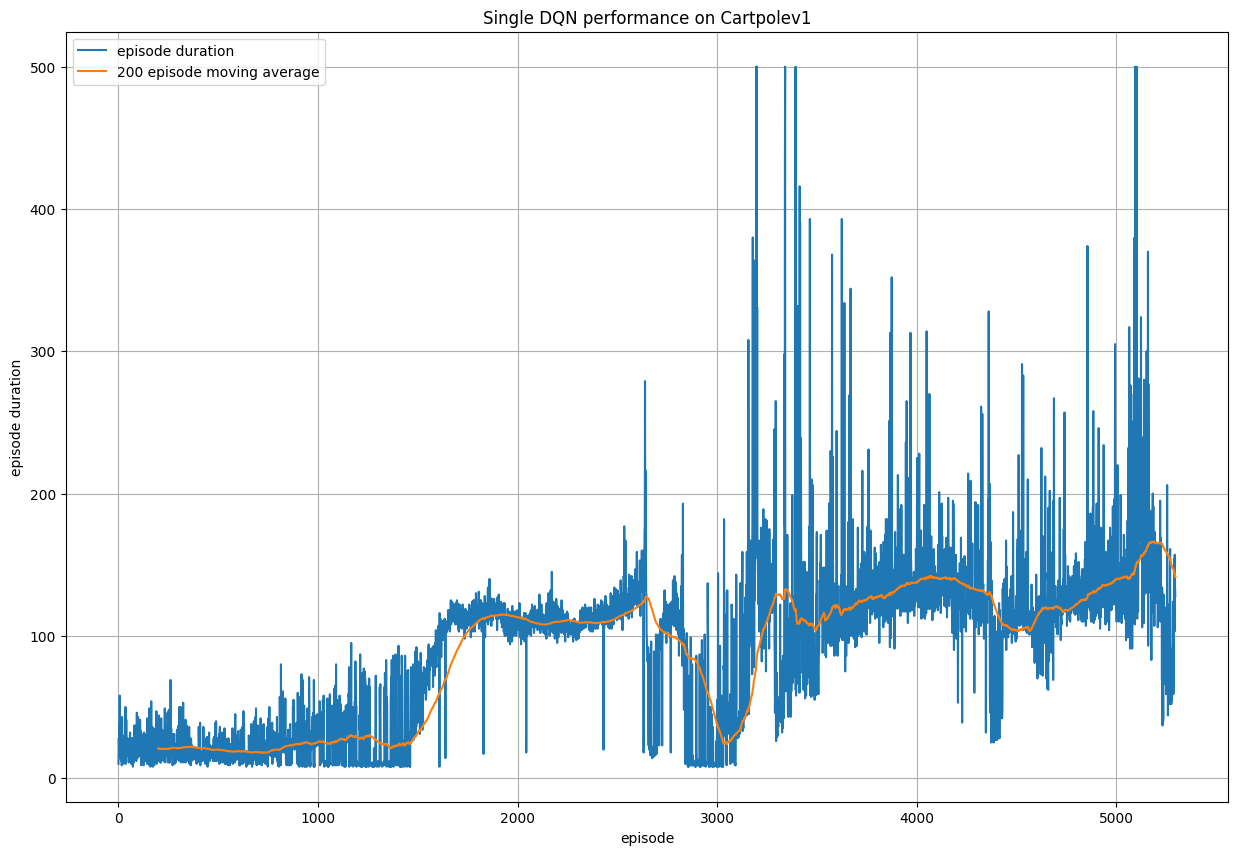

In [52]:
import pandas as pd

durations = pd.Series(episode_durations)
ra = durations.rolling(200).mean()

plt.figure(figsize=(15,10))
plt.plot(range(len(episode_durations)), episode_durations, label="episode duration")
plt.plot(range(len(episode_durations)), ra, label="200 episode moving average")
plt.title("Single DQN performance on Cartpolev1")
plt.xlabel("episode")
plt.ylabel("episode duration")
plt.grid('on')
plt.legend(loc="best")
plt.show()

# Public Implementation of DQN

In [44]:
# Write DQN network

class DQN(nn.Module):
    def __init__(self, n_observations, hidden_size, n_actions) -> None:
        super().__init__()
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.hidden_state = hidden_size
        self.proj1 = nn.Linear(n_observations, hidden_size)
        self.proj2 = nn.Linear(hidden_size, hidden_size)
        self.proj3 = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        x = F.relu(self.proj1(x))
        x = F.relu(self.proj2(x))
        return self.proj3(x)

In [45]:
# Write replay system

# Create a transition object
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class Replay:

    def __init__(self, max_length) -> None:
        # create memory store
        self.memory = deque([], maxlen=max_length)

    def save_memory(self, *args):
        self.memory.append(Transition(*args))

    def extract_memory(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [64]:
# Optimize the DQN

def optimize():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.extract_memory(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()

    print(state_action_values.shape, expected_state_action_values.unsqueeze(1).shape)

    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [65]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [66]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [67]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
hidden_size = 128
TAU = 0.005
LR = 1e-4


env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset(seed=42)
n_observation = len(observation)
n_actions = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
policy_net = DQN(n_observation, hidden_size, n_actions).to(device)
target_net = DQN(n_observation, hidden_size, n_actions).to(device)
policy_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = Replay(10000)
episode_durations = []

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.save_memory(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

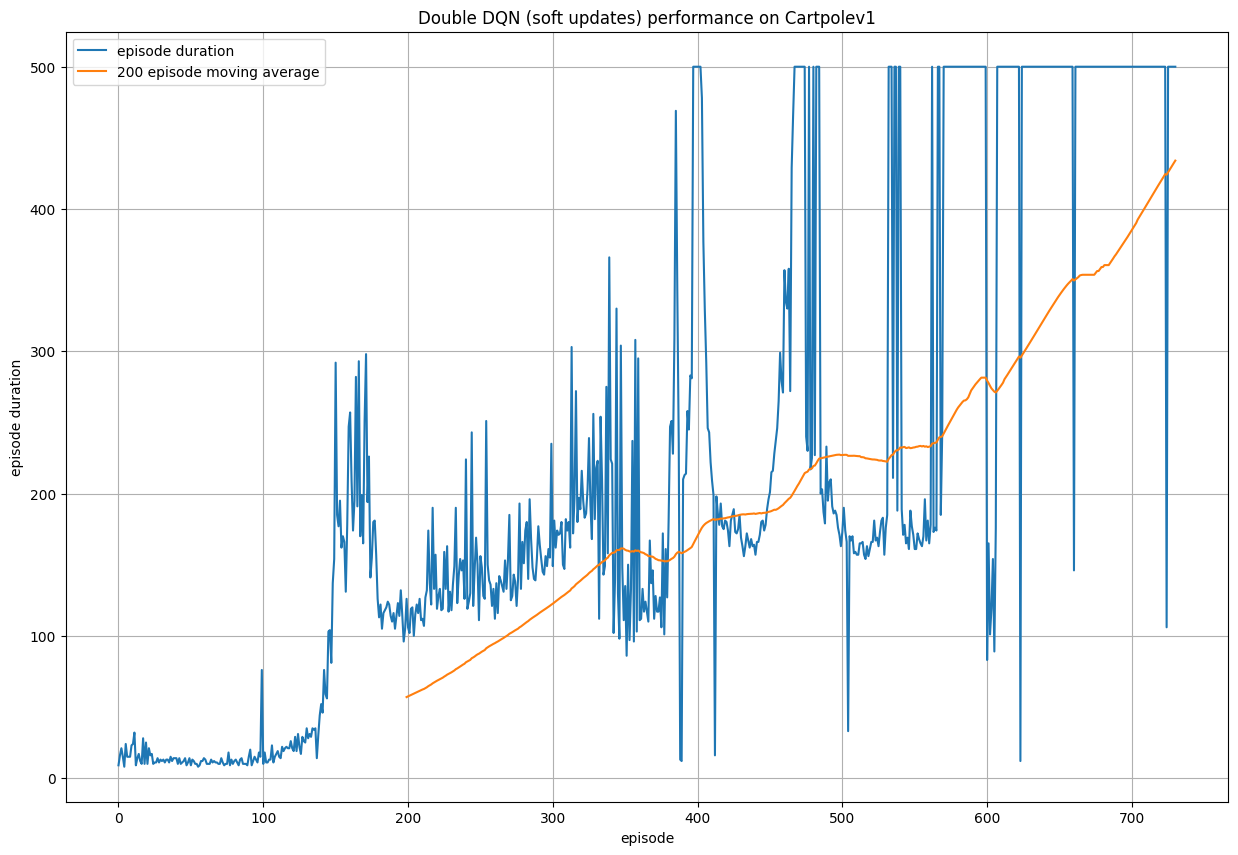

In [54]:
import pandas as pd

durations = pd.Series(episode_durations)
ra = durations.rolling(200).mean()

plt.figure(figsize=(15,10))
plt.plot(range(len(episode_durations)), episode_durations, label="episode duration")
plt.plot(range(len(episode_durations)), ra, label="200 episode moving average")
plt.title("Double DQN (soft updates) performance on Cartpolev1")
plt.xlabel("episode")
plt.ylabel("episode duration")
plt.grid('on')
plt.legend(loc="best")
plt.show()

In [55]:
from copy import deepcopy

durations = deepcopy(episode_durations)

In [ ]:
env.close()

# DQN Agent from personal library

In [1]:
import sys
sys.path.append("C:/Users/YuweiZhu/OneDrive - Alloyed/Documents/Market-Prediction-Research/terminal")
from models.deep_q_agent import DQNAgent

In [12]:
%reload_ext autoreload
%autoreload 2

In [23]:
agent = DQNAgent(double_dqn=True, 
                target_net_update='hard',
                tau=0.005,
                hard_update_interval=200,
                mem_length=10000, 
                environment='CartPole-v1', 
                gradient_clipping=100, 
                hidden_size_1=128,
                hidden_size_2=128)

In [24]:
loss = nn.SmoothL1Loss()

KeyboardInterrupt: 

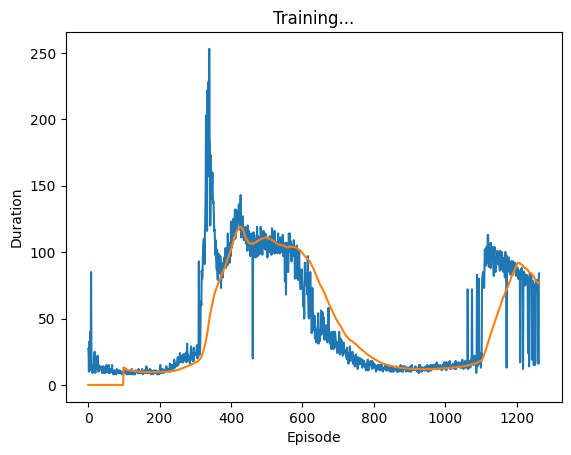

In [25]:
agent.train(episodes=5000, loss=loss)

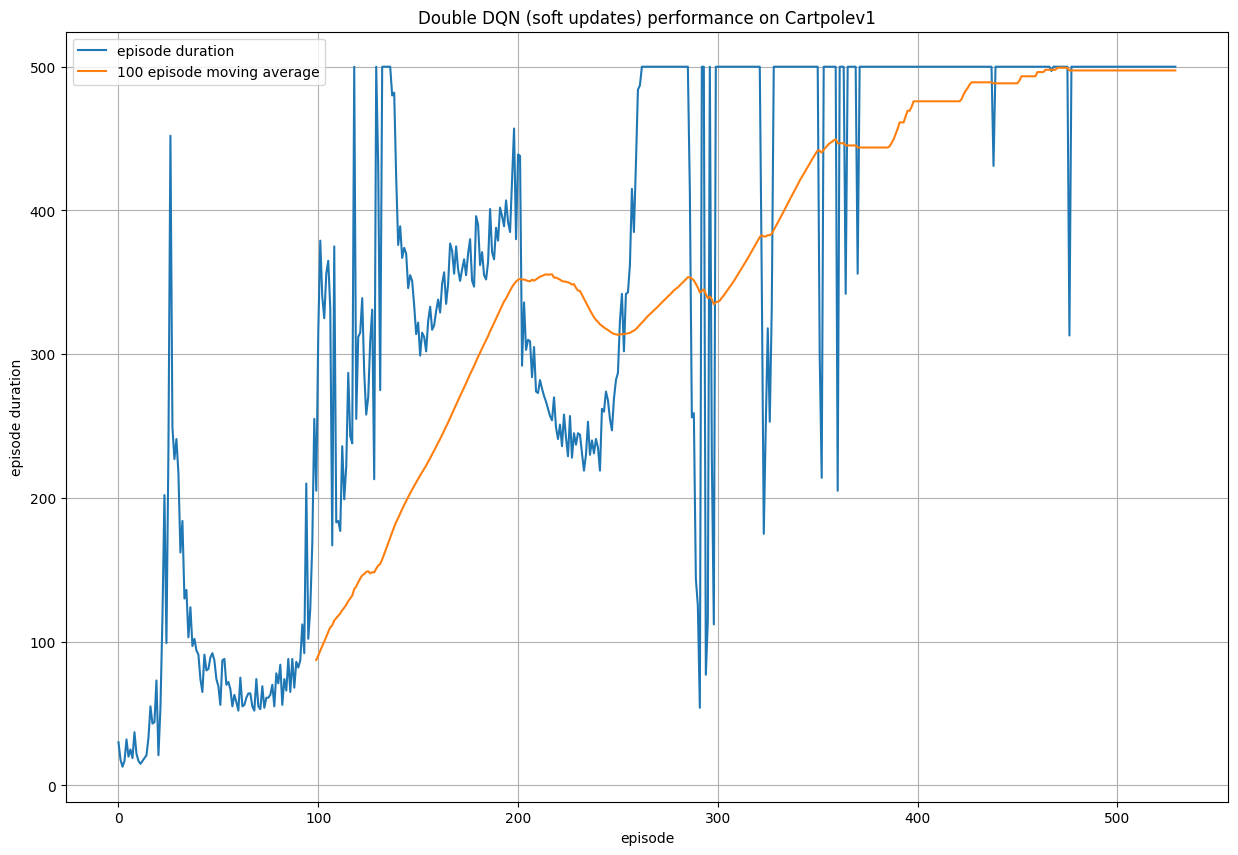

In [22]:
import pandas as pd

durations = pd.Series(agent.episode_durations)
ra = durations.rolling(100).mean()

plt.figure(figsize=(15,10))
plt.plot(range(len(agent.episode_durations)), agent.episode_durations, label="episode duration")
plt.plot(range(len(agent.episode_durations)), ra, label="100 episode moving average")
plt.title("Double DQN (soft updates) performance on Cartpolev1")
plt.xlabel("episode")
plt.ylabel("episode duration")
plt.grid('on')
plt.legend(loc="best")
plt.show()